# **DBSCAN**

This notebook implements **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**, using the **Spotify audio features dataset**.

DBSCAN is a density-based clustering algorithm that groups together points in high-density regions and labels low-density points as **noise**. Unlike K-Means:

- DBSCAN does **not require specifying k**
- It detects **arbitrary-shaped clusters**
- It identifies **outliers naturally**
- It relies on two parameters:  
  - **eps** — neighborhood radius  
  - **min_samples** — minimum neighbors needed to form a dense region  

We follow the same pipeline as the rest of the repository:

1. Load & preprocess the Spotify dataset  
2. Standardize features  
3. Implement DBSCAN from scratch  
4. Use k-distance plot to determine eps  
5. Cluster the dataset  
6. Visualize with PCA  
7. Analyze cluster counts & noise  


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors


In [5]:
df = pd.read_csv("topsongs.csv")

features = [
    "danceability","energy","loudness","speechiness","acousticness",
    "instrumentalness","liveness","valence","tempo"
]

X = df[features].values

# Standardize
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

X_std[:5]


array([[ 0.59525376,  0.74413046,  0.03540329, -0.62274794,  0.98697358,
        -0.17331627,  1.23571936,  1.55025566, -0.92986699],
       [-1.66288167,  1.15668497,  0.30751937, -0.56969739, -0.68466912,
        -0.17351798,  3.06315751,  0.59920732,  1.06094401],
       [-0.98615338, -1.46925722, -1.8078469 , -0.77565836,  0.25415127,
        -0.17351798,  0.49621132, -1.23948612,  0.62077942],
       [-0.82943736,  1.26146072,  0.74983733, -0.59258194, -0.59234505,
        -0.17336413,  1.17883413, -0.0348249 , -0.00484257],
       [-0.38065966,  1.35968798,  0.36546043, -0.5405716 , -0.50867636,
        -0.16166597, -0.68771262,  1.48232363,  1.94854313]])

## **DBSCAN Algorithm**

DBSCAN uses two key ideas:

### **1. Core Point**
A point with at least `min_samples` neighbors within distance `eps`.

### **2. Density-Reachable**
If A is core and B is within eps of A → B is density-reachable.

### **3. Clusters**
Start from a core point and expand outward by recursively adding reachable points.

### **4. Noise**
Points not belonging to any cluster.

We implement:

- Euclidean distance computation  
- Region query (neighbors within eps)  
- Core/border/noise classification  
- Cluster expansion  


In [8]:
def region_query(X, point_idx, eps):
    distances = np.linalg.norm(X - X[point_idx], axis=1)
    return np.where(distances <= eps)[0]

def expand_cluster(X, labels, point_idx, neighbors, cluster_id, eps, min_samples):
    labels[point_idx] = cluster_id

    i = 0
    while i < len(neighbors):
        n_idx = neighbors[i]
        
        if labels[n_idx] == -1:      # previously noise → now border
            labels[n_idx] = cluster_id
        
        elif labels[n_idx] == 0:     # unvisited
            labels[n_idx] = cluster_id
            n_neighbors = region_query(X, n_idx, eps)
            
            if len(n_neighbors) >= min_samples:
                neighbors = np.concatenate([neighbors, n_neighbors])
        
        i += 1

def dbscan(X, eps, min_samples):
    n = X.shape[0]
    labels = np.zeros(n, dtype=int)  # 0 = unvisited
    cluster_id = 0

    for i in range(n):
        if labels[i] != 0:
            continue

        neighbors = region_query(X, i, eps)

        # Not enough points → noise
        if len(neighbors) < min_samples:
            labels[i] = -1
        else:
            cluster_id += 1
            expand_cluster(X, labels, i, neighbors, cluster_id, eps, min_samples)

    return labels


## **Choosing eps using the K-Distance Plot**

To select a good eps, DBSCAN practitioners plot the **k-distance graph**:

1. Compute distance to the *k* nearest neighbor for each point  
2. Sort distances  
3. Look for the **"elbow"** → transition from dense regions to sparse regions  

We use **k = 4** (min_samples - 1).  


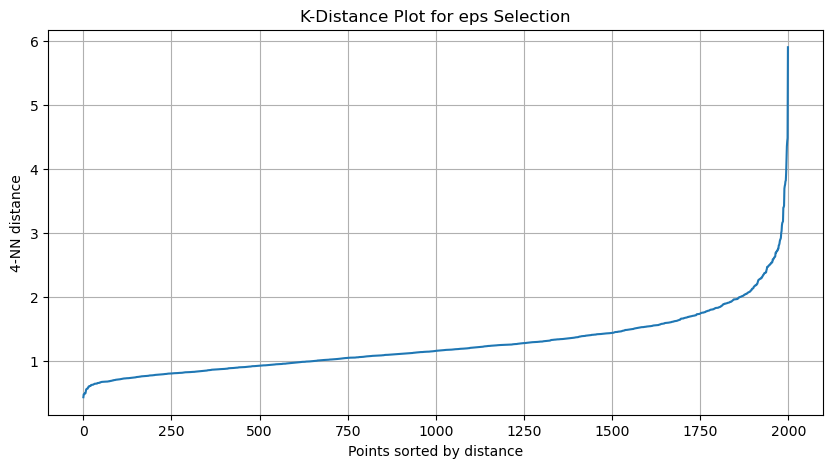

In [11]:
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(X_std)
distances, indices = neighbors_fit.kneighbors(X_std)

k_distances = np.sort(distances[:, 3])

plt.figure(figsize=(10,5))
plt.plot(k_distances)
plt.title("K-Distance Plot for eps Selection")
plt.xlabel("Points sorted by distance")
plt.ylabel("4-NN distance")
plt.grid(True)
plt.show()


In [13]:
eps = 0.7     # adjust based on elbow
min_samples = 5

labels = dbscan(X_std, eps=eps, min_samples=min_samples)

labels[:20], len(set(labels))


(array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1]),
 8)

## **PCA Visualization**

DBSCAN operates in 9-dimensional space, but we use PCA to visualize clusters:

- PC1 & PC2 capture the largest variance  
- Each cluster receives a color  
- Noise points appear as label **−1**  


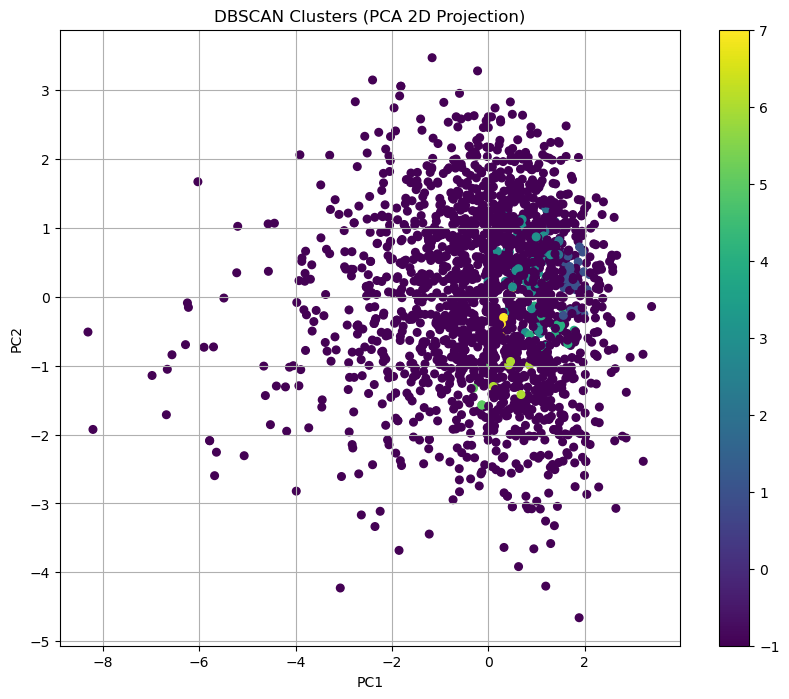

In [16]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

plt.figure(figsize=(10,8))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', s=30)
plt.title("DBSCAN Clusters (PCA 2D Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter)
plt.grid(True)
plt.show()


In [18]:
unique, counts = np.unique(labels, return_counts=True)
summary = dict(zip(unique, counts))
summary


{-1: 1894, 1: 30, 2: 8, 3: 38, 4: 14, 5: 5, 6: 5, 7: 6}

## **Additional DBSCAN Visualizations**

To better understand how DBSCAN partitions dense and sparse regions, we include two additional plots:

### **1. Noise vs Cluster Map**
Separates noise points (label = -1) from clustered points to show DBSCAN’s outlier detection strength.

### **2. Density Contour Plot (PCA Space)**
Uses a 2D Kernel Density Estimate to illustrate where DBSCAN found dense groupings—highlighting the algorithm's density-based behavior.

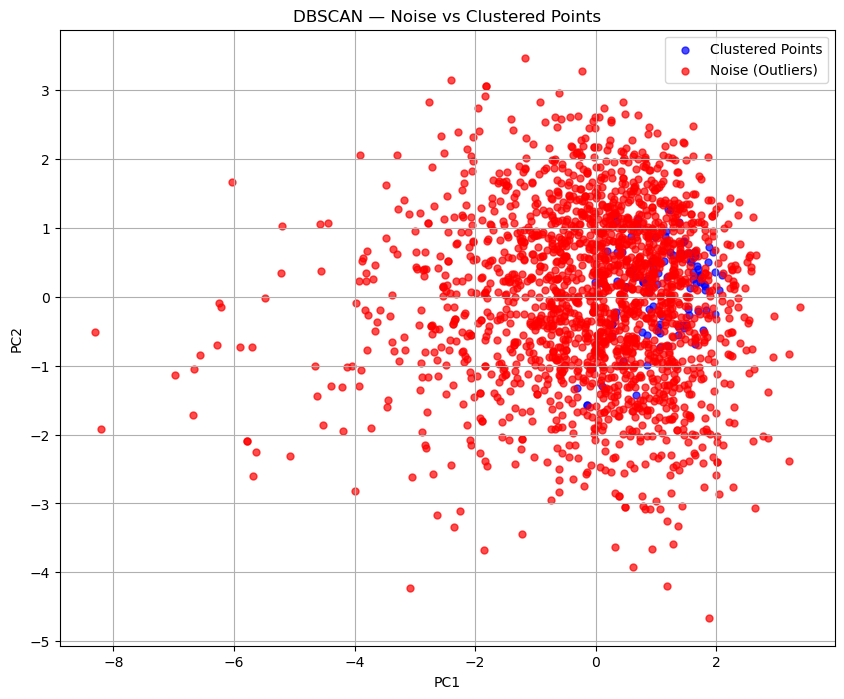

In [21]:
# --- Noise vs Cluster Visualization ---
plt.figure(figsize=(10,8))

noise_mask = labels == -1
cluster_mask = labels != -1

plt.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1],
            c='blue', s=25, label='Clustered Points', alpha=0.7)
plt.scatter(X_pca[noise_mask, 0], X_pca[noise_mask, 1],
            c='red', s=25, label='Noise (Outliers)', alpha=0.7)

plt.title("DBSCAN — Noise vs Clustered Points")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()


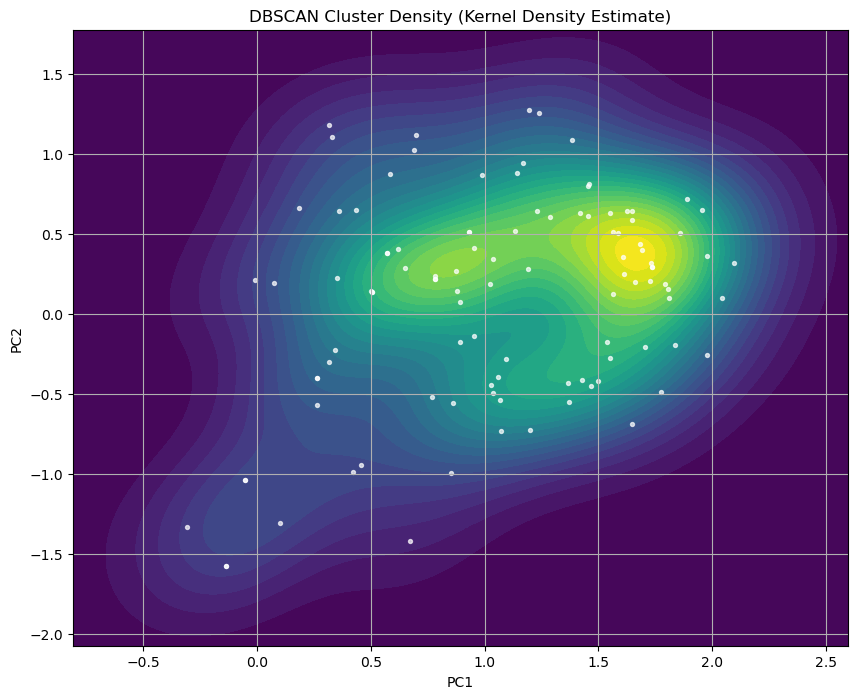

In [23]:
# --- Density Contour Plot ---
from scipy.stats import gaussian_kde

# Only cluster points (exclude noise)
cluster_points = X_pca[labels != -1]

# Perform KDE
kde = gaussian_kde(cluster_points.T)

# Create grid for contour
x_min, x_max = cluster_points[:,0].min() - 0.5, cluster_points[:,0].max() + 0.5
y_min, y_max = cluster_points[:,1].min() - 0.5, cluster_points[:,1].max() + 0.5

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)

grid_coords = np.vstack([xx.ravel(), yy.ravel()])
density = kde(grid_coords).reshape(xx.shape)

plt.figure(figsize=(10,8))
plt.contourf(xx, yy, density, levels=30, cmap='viridis')
plt.scatter(cluster_points[:,0], cluster_points[:,1], c='white', s=8, alpha=0.7)

plt.title("DBSCAN Cluster Density (Kernel Density Estimate)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


### **DBSCAN Interpretation**

The DBSCAN clustering results reveal how density-based grouping behaves on the Spotify audio feature space. A sample of the standardized feature vectors:

[[ 0.59525376 0.74413046 0.03540329 -0.62274794 0.98697358 -0.17331627
1.23571936 1.55025566 -0.92986699]
[-1.66288167 1.15668497 0.30751937 -0.56969739 -0.68466912 -0.17351798
3.06315751 0.59920732 1.06094401]
[-0.98615338 -1.46925722 -1.80784690 -0.77565836 0.25415127 -0.17351798
0.49621132 -1.23948612 0.62077942]
[-0.82943736 1.26146072 0.74983733 -0.59258194 -0.59234505 -0.17336413
1.17883413 -0.03482490 -0.00484257]
[-0.38065966 1.35968798 0.36546043 -0.54057160 -0.50867636 -0.16166597
-0.68771262 1.48232363 1.94854313]]


When projected into PCA space, the DBSCAN scatterplot shows that **the densest grouping of points lies between approximately -1 and 2 on both PC1 (x-axis) and PC2 (y-axis)**. This matches the algorithm’s identification of a single large high-density region, with several smaller peripheral clusters.

The distribution of DBSCAN-assigned labels confirms this density pattern:

{-1: 1894, 1: 30, 2: 8, 3: 38, 4: 14, 5: 5, 6: 5, 7: 6}


Key observations:

- **Most points (1,894 samples)** were labeled **-1 (noise)**, indicating that the dataset does not form many strongly dense pockets in high-dimensional space.
- A few **very small, tightly packed clusters** (5–38 points each) were detected, suggesting isolated regions of higher local density.
- The PCA visualization supports this: only the central region between **PC1 ∈ [-1, 2]** and **PC2 ∈ [-1, 2]** shows meaningful structure, while the rest of the space is sparse.

Overall, DBSCAN identifies a dominant high-density core and several minor clusters, while classifying most points as noise due to the diffuse, continuous nature of Spotify feature distributions.
